# TextCNN

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!pip install -q jieba pydot graphviz
!apt-get install graphviz > /dev/null

In [0]:
import time
import jieba
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D
from keras.layers import Dropout, Dense, Concatenate, Flatten, LeakyReLU
from keras.initializers import Constant
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

seed = 233666
path = '/gdrive/My Drive/Colab Notebooks/'

jieba.setLogLevel(20)

## 1 Data

In [0]:
X = pickle.load(open(path + 'X_word.p', 'rb'))
y = pickle.load(open(path + 'y.p', 'rb'))
word_index, e_mat = pickle.load(open(path + 'embeddings_word.p', 'rb'))

In [0]:
def class_ratio(y):
    s, l = np.sum(y), len(y)
    print('class1 / len =', s, '/', l, '=', '%f' % (s / l))

# class_ratio(y)

def test_maxlen(test_list):
    """Number of texts maxlen will influence."""
    return [np.sum([[y_, 1] if len(x) > Tx else [0, 0] 
                   for x, y_ in zip(X, y)], axis=0).tolist()
            for Tx in test_list]

# test_maxlen([128, 256, 512, 1024, 2048, 4096])

Zero-pad.

In [0]:
Tx = 256
X = pad_sequences(X, maxlen=Tx, truncating='post')

Split.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=1/9, random_state=seed, stratify=y_train)

## 2 Model

Inspired by [Kim (2014)](https://www.aclweb.org/anthology/D14-1181) and [Zhang et al. (2015)](https://arxiv.org/abs/1510.03820).

### 2.1 Build

In [0]:
def text_cnn(region_sizes):
    """Recieve a list of region sizes, which can contain 0."""
    i = Input(shape=(Tx,), name='Sentence')
    X = Embedding(*e_mat.shape, embeddings_initializer=Constant(e_mat),
                  trainable=True, name='WordVec')(i)
    Xs = []
    region_sizes = [s for s in region_sizes if s > 0]
    for region_size in region_sizes:
        Xi = Conv1D(1, region_size)(X)
        Xi = LeakyReLU(0.1)(Xi)
        Xi = MaxPooling1D(Xi.shape.as_list()[1])(Xi)
        Xs.append(Xi)
    X = Concatenate()(Xs) if len(region_sizes) > 1 else Xs[0]
    X = Flatten()(X)
    X = Dropout(0.5, seed=seed)(X)
    X = Dense(1, activation='sigmoid')(X)
    return Model(inputs=i, outputs=X)

text_cnn([7, 0]).summary()

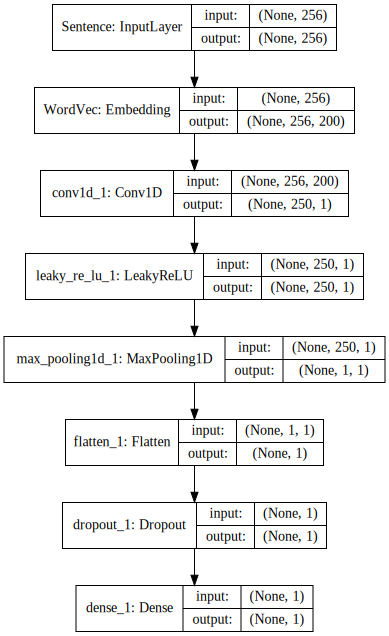

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(text_cnn([7, 0]), show_shapes=True).create(prog='dot', format='svg'))

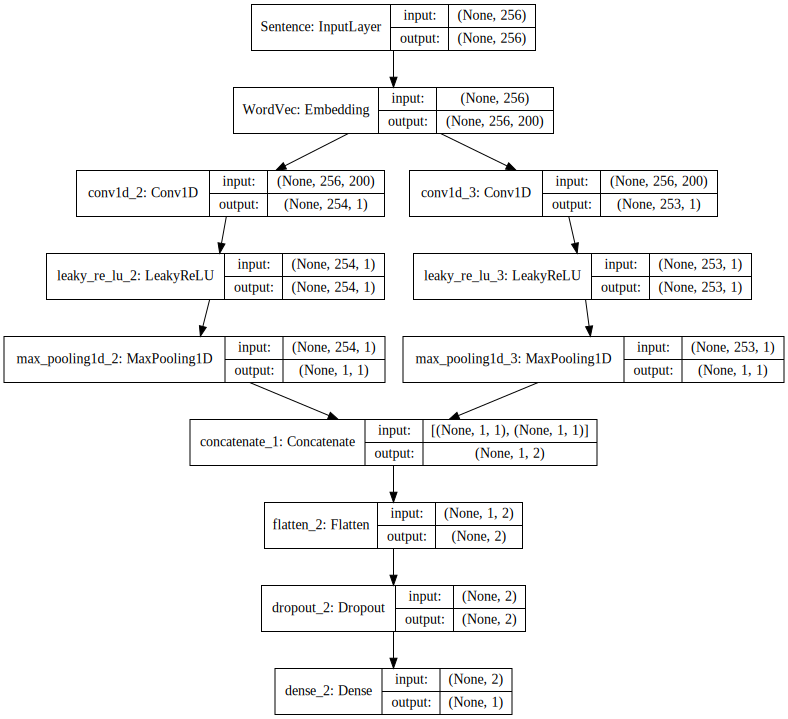

In [0]:
SVG(model_to_dot(text_cnn([3, 4, 0, 0]), show_shapes=True).create(prog='dot', format='svg'))

Compile config.

In [0]:
def f1(y_true, y_pred):
    return tf.py_func(f1_score, (y_true, y_pred > 0.5), tf.double)

compile_config = {'loss': 'binary_crossentropy', 'metrics': ['acc', f1]}

Callbacks.

In [0]:
def checkpointer(name='model', save_weights_only=True):
    return ModelCheckpoint(path + 'weights/' + str(name) + '.hdf5',
                           'val_f1', mode='max', verbose=1,
                           save_best_only=True,
                           save_weights_only=save_weights_only)

def earlystopper(patience=3):
    return EarlyStopping('val_f1', patience=patience, verbose=1, mode='max',
                         restore_best_weights=True)

def lr_reducer(patience=1):
    return ReduceLROnPlateau('val_f1', 0.5, patience, 1, 'max')

### 2.2 Choose region size

By holdout cross-validation and big batch size for speed.

- Line-search over the single filter region size to find the ‘best’ single region size. 
- It may be worth exploring combining multiple filters using regions sizes near this single best size.

#### 2.2.1 Single region size

In [0]:
single_region_sizes = [1, 3, 5, 7, 9, 11, 13, 15]
single_f1s = []
# single_f1s = [0.9240704040900427, 0.9419539729588094, 0.946276105089114,
#               0.949119298415185, 0.9507171235806062, 0.9521449645421297,
#               0.7933238256923938, 0.783414052232246]

for region_size in single_region_sizes[len(single_f1s):]:
    print('region_size:', region_size)
    model = text_cnn([region_size])
    model.compile(optimizer=Adam(clipnorm=3), **compile_config)
    model.fit(X_train, y_train, batch_size=512, epochs=200, verbose=0,
              validation_data=(X_val, y_val), 
              callbacks=[checkpointer(), earlystopper(), lr_reducer()])
    single_f1s.append(f1_score(y_val, model.predict(X_val) > 0.5))
    print('f1s so far:', single_f1s)

In [0]:
def best_size_f1(sizes, f1s):
    best_index = np.argmax(f1s)
    best_size = sizes[best_index]
    best_f1 = f1s[best_index]
    print('best region_size:', best_size)
    print('f1 on val:', best_f1)
    print('\nsize', 'f1', sep='\t')
    for size, f1 in zip(sizes, f1s):
        print(size, f1, sep='\t')
    return best_size, best_f1

In [0]:
best_single_size, best_single_f1s = best_size_f1(single_region_sizes, 
                                                 single_f1s)

#### 2.2.2 Multiple region size

In [0]:
def gen_multi_region_sizes(size):
    size_range = [size - 1, size, size + 1] if size > 1 else [1, 2, 3]
    return list({tuple(sorted([s1, s2, s3])) for s1 in size_range
                 for s2 in size_range for s3 in size_range})

multi_region_sizes = gen_multi_region_sizes(best_single_size)
multi_f1s = []
# multi_f1s = [0.9550137817072694, 0.9531340011912312, 0.9535508304667741, 
#              0.9536456192051067, 0.9505853533541159]

for region_size in multi_region_sizes[len(multi_f1s):]:
    print('region_size:', region_size)
    model = text_cnn(region_size)
    model.compile(optimizer=Adam(clipnorm=3), **compile_config)
    model.fit(X_train, y_train, batch_size=512, epochs=200, verbose=0,
              validation_data=(X_val, y_val),
              callbacks=[checkpointer(), earlystopper(), lr_reducer()])
    multi_f1s.append(f1_score(y_val, model.predict(X_val) > 0.5))
    print('f1s so far:', multi_f1s)

In [0]:
best_multi_size, best_multi_f1s = best_size_f1(multi_region_sizes, multi_f1s)

#### 2.2.3 Final comparison

In [0]:
best_size, best_f1 = best_size_f1(single_region_sizes + multi_region_sizes, 
                                   single_f1s + multi_f1s)

### 2.3 Train with small batch size

In [0]:
model = text_cnn(best_size)
model.compile(**compile_config)
model.fit(X_train, y_train, batch_size=256, epochs=200, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer('final_' + str(region_size), False),
                     earlystopper(10), lr_reducer(3)])

In [0]:
# model = load_model(path + 'final_(10, 11, 11).hdf5', custom_objects={'f1': f1})

In [0]:
# f1_score(y_val, model.predict(X_val) > 0.5)

### 2.4 Test

In [0]:
f1_score(y_test, model.predict(X_test) > 0.5)

0.9868052778888444

## 3 Predict

Prediction time.

In [0]:
unlabelled = pd.read_csv(path + 'unlabelled.txt', header=None, nrows=1000)[0].tolist()

In [0]:
ts = []
for i in range(100):
    t1 = time.time()
    X_unseen = pad_sequences([[word_index[w]
                               if w in word_index.keys() else word_index['<UNK>'] 
                               for w in jieba.cut_for_search(text)]
                              for text in unlabelled], maxlen=256)
    model.predict(X_unseen)
    t2 = time.time()
    ts.append(t2 - t1)

In [0]:
print(sum(ts) / 100, 's for 1000 msgs.')

0.3472757625579834 s for 1000 msgs.


Seeing is believing.

In [0]:
X_show = ['.x月xx日推出凭证式国债x年期x.xx.xx%，x年期x.xx%到期一次还本付息。真情邮政，为您竭诚服务！  咨询电话xxxx-xx',
'一边是爱琴海7日浪漫之旅~和公司同事们~一边是南京双排7日撸啊撸之旅~和基友~怎么选择好纠结',
"庆x'x节本会所优惠活动，为答谢新老顾客的支持与厚爱，，面部特卡:xxx元/xx次，身体活动，带脉减小肚腩:xxxx元/xx次，，肠胃",
'著名医学专家、北京军区总医院主任医师华益慰图丨健康时报文丨新华网、健康时报这篇文章']

for text in X_show:
    t1 = time.time()
    X_show = pad_sequences([[word_index[w]
                             if w in word_index.keys() else word_index['<UNK>'] 
                             for w in jieba.cut_for_search(text)]], maxlen=256)    
    y_show = model.predict(X_show)[0][0]
    t2 = time.time()
    print(t2 - t1, 's , confidence:', y_show if y_show > 0.5 else 1 - y_show)

0.005984783172607422 s , confidence: 1.0
0.005811452865600586 s , confidence: 0.9999410322234326
0.005015850067138672 s , confidence: 1.0
0.003549337387084961 s , confidence: 0.9999605094999424
